In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import keras.models
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Conv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed

In [0]:

from keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout,Add
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers

In [0]:
set_random_seed(300)

In [4]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/drive/


In [5]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


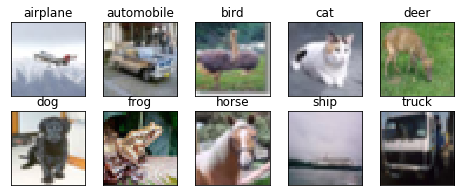

In [7]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [11]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(train_labels, 10)
Y_test = np_utils.to_categorical(test_labels, 10)

### **Resnet Model:**

In [0]:
def block(n_output, upscale=False):
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # second pre-activation
        h = BatchNormalization()(x)
        h = Activation(relu)(h)
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return add([f, h])
    
    return f

In [0]:
# input tensor is the 28x28 grayscale image
input_tensor = Input((32,32, 3))

# first conv2d with post-activation to transform the input data to some reasonable form
x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = BatchNormalization()(x)
x = Activation(relu)(x)

# F_1
x = block(16)(x)
# F_2
x = block(16)(x)

# F_3
# H_3 is the function from the tensor of size 28x28x16 to the the tensor of size 28x28x32
# and we can't add together tensors of inconsistent sizes, so we use upscale=True
x = block(32, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
# F_4
x = block(32)(x)                     # !!! <------- Uncomment for local evaluation
# F_5
x = block(32)(x)                     # !!! <------- Uncomment for local evaluation

# F_6
x = block(48, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
# F_7
x = block(48)(x)                     # !!! <------- Uncomment for local evaluation

# last activation of the entire network's output
x = BatchNormalization()(x)
x = Activation(relu)(x)

# average pooling across the channels
# 28x28x48 -> 1x48
x = GlobalAveragePooling2D()(x)

# dropout for more robust learning
x = Dropout(0.2)(x)

# last softmax layer
x = Dense(units=10, kernel_regularizer=regularizers.l2(0.01))(x)
x = Activation(softmax)(x)



W0811 21:39:32.918269 139930738714496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 21:39:32.920344 139930738714496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 21:39:32.936108 139930738714496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 21:39:32.989215 139930738714496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811 21:39:32.990355 1399307387

In [0]:
model = Model(inputs=input_tensor, outputs=x)

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0811 21:39:42.687362 139930738714496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

### Cutout

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### LR Finder

In [0]:
from keras.callbacks import Callback
import os
import keras.backend as K

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/128))

model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 1, 
                                 callbacks=[lr_finder],verbose=1)

NameError: ignored

### Save model with best accuracy

In [0]:


from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import optimizers

#model = model1()

filepath='saved_model1'

checkpointer = ModelCheckpoint(filepath=filepath, monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)

# Compile the model
sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
EPOCHS = 50

datagen = ImageDataGenerator(featurewise_center=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1),featurewise_std_normalization=True, rotation_range=20, horizontal_flip=True)
datagen.fit(train_features)

train_flow = datagen.flow(train_features, train_labels, batch_size=BATCH_SIZE)
valid_flow = datagen.flow(test_features, test_labels, batch_size=BATCH_SIZE, shuffle=False)

STEP_SIZE_TRAIN=train_flow.n//train_flow.batch_size
STEP_SIZE_VALID=valid_flow.n//valid_flow.batch_size

history = model.fit_generator(train_flow,
                    epochs=EPOCHS,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_flow,
                    validation_steps=STEP_SIZE_VALID,callbacks=[checkpointer,lr_reducer], verbose=1)

Epoch 1/50
781/781 [==============================] - 34s 43ms/step - loss: 2.6486 - acc: 0.2829 - val_loss: 1.9488 - val_acc: 0.3392

Epoch 00001: val_acc improved from -inf to 0.33924, saving model to saved_model1
Epoch 2/50
781/781 [==============================] - 30s 38ms/step - loss: 1.8866 - acc: 0.3428 - val_loss: 1.8521 - val_acc: 0.3525

Epoch 00002: val_acc improved from 0.33924 to 0.35246, saving model to saved_model1
Epoch 3/50
781/781 [==============================] - 30s 38ms/step - loss: 1.8045 - acc: 0.3856 - val_loss: 2.4404 - val_acc: 0.2803

Epoch 00003: val_acc did not improve from 0.35246
Epoch 4/50
781/781 [==============================] - 30s 38ms/step - loss: 1.7520 - acc: 0.4152 - val_loss: 2.1755 - val_acc: 0.3287

Epoch 00004: val_acc did not improve from 0.35246
Epoch 5/50
781/781 [==============================] - 30s 38ms/step - loss: 1.7222 - acc: 0.4316 - val_loss: 1.7886 - val_acc: 0.4104

Epoch 00005: val_acc improved from 0.35246 to 0.41043, savin

KeyboardInterrupt: ignored

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0075.
  2/390 [..............................] - ETA: 26s - loss: 1.1708 - acc: 0.6484

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`


390/390 [==============================] - 18s 46ms/step - loss: 1.4527 - acc: 0.5557 - val_loss: 1.9002 - val_acc: 0.4384
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0056861259.
390/390 [==============================] - 18s 46ms/step - loss: 1.2642 - acc: 0.6256 - val_loss: 1.8446 - val_acc: 0.4787
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0045787546.
390/390 [==============================] - 18s 47ms/step - loss: 1.2174 - acc: 0.6355 - val_loss: 1.6776 - val_acc: 0.4916
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0038323965.
390/390 [==============================] - 18s 47ms/step - loss: 1.1848 - acc: 0.6516 - val_loss: 2.0663 - val_acc: 0.4380
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0032952548.
390/390 [==============================] - 18s 47ms/step - loss: 1.1495 - acc: 0.6617 - val_loss: 1.3288 - val_acc: 0.6021
Epoch 6/50

Epoch 00006: LearningRateSche

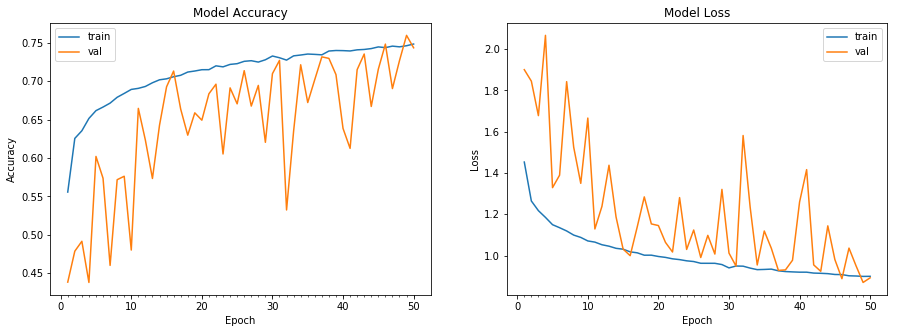

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                             horizontal_flip=True)

from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.0075 * 1/(1 + 0.319 * epoch), 10)

# train the model
start = time.time()
# Train the model
my_model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                    
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(my_model_info)

### Model Trained with  SGD, Momemtum = 0.9 and verbose = 0

### Accuracy 

In [0]:
score = model.evaluate(X_test, Y_test, batch_size=128)
print (score[1])

10000/10000 [==============================] - 1s 89us/step
0.8783


## Misclassfied images

In [0]:
Y_pred = model.predict(X_test)

In [0]:
import pandas as pd

def decode(datum):
    return np.argmax(datum)
  
ytest = []
ypred = []

for i in range(len(Y_test)):
  ytest.append(decode(Y_test[i]))
  ypred.append(decode(Y_pred[i]))

df = pd.DataFrame()
df['Actual'] = ytest
df['Pred']  =  ypred

In [0]:
import random
misclassified = df.index[df['Actual']!=df['Pred']].tolist()
misclassified_images = random.sample(misclassified, 25)


### GradCAM on the any 25 misclassified images

Image index is 7446
actual class dog
predicted class frog


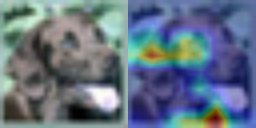

 
Image index is 6859
actual class cat
predicted class automobile


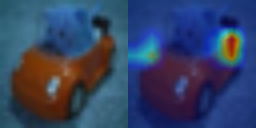

 
Image index is 4964
actual class dog
predicted class deer


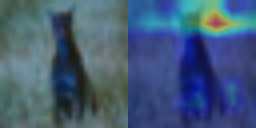

 
Image index is 9248
actual class airplane
predicted class ship


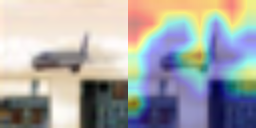

 
Image index is 8196
actual class cat
predicted class truck


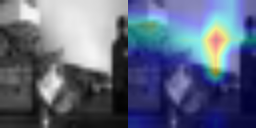

 
Image index is 8806
actual class cat
predicted class bird


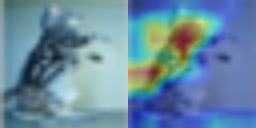

 
Image index is 8112
actual class cat
predicted class frog


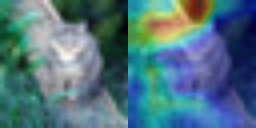

 
Image index is 9040
actual class bird
predicted class dog


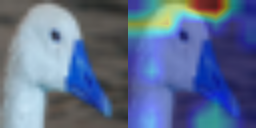

 
Image index is 4140
actual class dog
predicted class horse


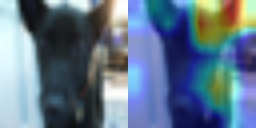

 
Image index is 9926
actual class cat
predicted class frog


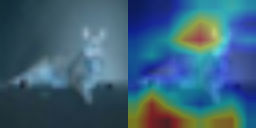

 
Image index is 1727
actual class truck
predicted class automobile


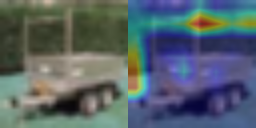

 
Image index is 9949
actual class cat
predicted class bird


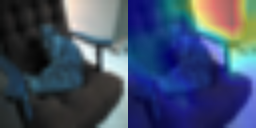

 
Image index is 4476
actual class automobile
predicted class airplane


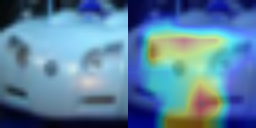

 
Image index is 6210
actual class deer
predicted class dog


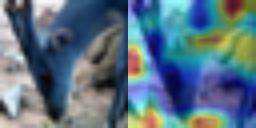

 
Image index is 2205
actual class dog
predicted class cat


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


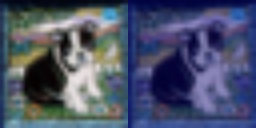

 
Image index is 4247
actual class dog
predicted class horse


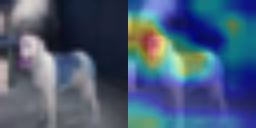

 
Image index is 6382
actual class deer
predicted class cat


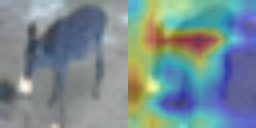

 
Image index is 1128
actual class deer
predicted class dog


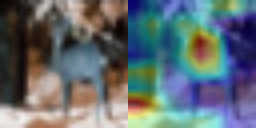

 
Image index is 9960
actual class bird
predicted class airplane


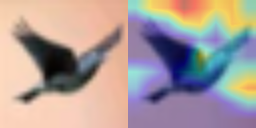

 
Image index is 6856
actual class frog
predicted class cat


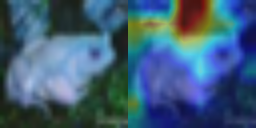

 
Image index is 6311
actual class cat
predicted class airplane


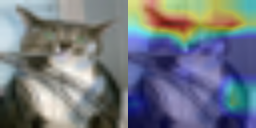

 
Image index is 5417
actual class deer
predicted class cat


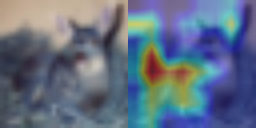

 
Image index is 1791
actual class deer
predicted class frog


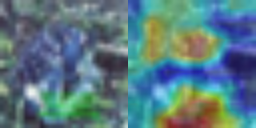

 
Image index is 2081
actual class cat
predicted class frog


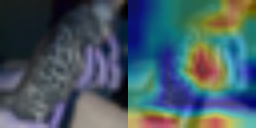

 
Image index is 1163
actual class cat
predicted class dog


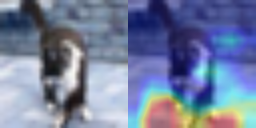

In [0]:
import cv2
from google.colab.patches import cv2_imshow

images = misclassified_images

for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2D_8")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  img = (testX[j])
  img = cv2.resize(img,(128,128))
  heatmap = cv2.resize(heatmap, (128, 128))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  concatimg = cv2.hconcat([img,superimposed_img])
  
  # Display the concatenated image
  print ("Image index is " + str(j))
  print ("actual class " + str(class_names[df['Actual'][j]]))
  print ("predicted class " + str(class_names[df['Pred'][j]]))
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1

## ***LR Finder:***

In [0]:
from keras.callbacks import Callback
import os
import keras.backend as K

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                             horizontal_flip=True)


In [0]:

# train the model
start = time.time()
# Train the model
my_model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                    
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[checkpointer,lr_reducer])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(my_model_info)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  
W0811 21:43:38.308009 139930738714496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a fu

Epoch 1/50
 25/390 [>.............................] - ETA: 1:34 - loss: 4.4589 - acc: 0.1616

### resnet original model

In [0]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# Input image dimensions.
input_shape = train_features.shape[1:]

In [25]:
 model = resnet_v1(input_shape=input_shape, depth=depth)

W0812 05:28:08.574057 140535361103744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0812 05:28:08.636190 140535361103744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 05:28:08.637243 140535361103744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0812 05:28:12.511179 140535361103744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0812 05:28:14.

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

W0812 05:29:40.415836 140535361103744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
import os

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'resnet.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_features)


In [47]:
 # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_features, train_labels, batch_size=128),
                        samples_per_epoch = train_features.shape[0],
                        validation_data=(test_features, test_labels),
                        epochs=20, verbose=1, workers=4,
                        callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., epochs=20, verbose=1, workers=4, callbacks=[<keras.ca..., steps_per_epoch=390)`
  """


Epoch 1/20
Learning rate:  0.001
390/390 [==============================] - 36s 92ms/step - loss: 1.6654 - acc: 0.4574 - val_loss: 1.8028 - val_acc: 0.4260

Epoch 00001: val_acc improved from -inf to 0.42600, saving model to /content/saved_models/resnet.h5
Epoch 2/20
Learning rate:  0.001
390/390 [==============================] - 28s 71ms/step - loss: 1.2833 - acc: 0.5951 - val_loss: 1.5592 - val_acc: 0.5306

Epoch 00002: val_acc improved from 0.42600 to 0.53060, saving model to /content/saved_models/resnet.h5
Epoch 3/20
Learning rate:  0.001
390/390 [==============================] - 28s 71ms/step - loss: 1.1103 - acc: 0.6576 - val_loss: 1.5523 - val_acc: 0.5724

Epoch 00003: val_acc improved from 0.53060 to 0.57240, saving model to /content/saved_models/resnet.h5
Epoch 4/20
Learning rate:  0.001
390/390 [==============================] - 28s 71ms/step - loss: 0.9895 - acc: 0.7037 - val_loss: 0.9898 - val_acc: 0.7051

Epoch 00004: val_acc improved from 0.57240 to 0.70510, saving mode